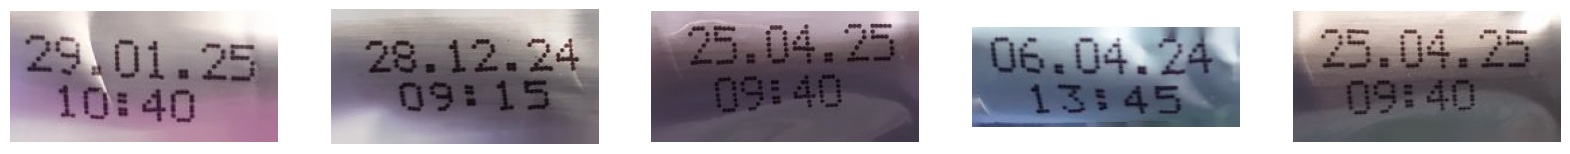

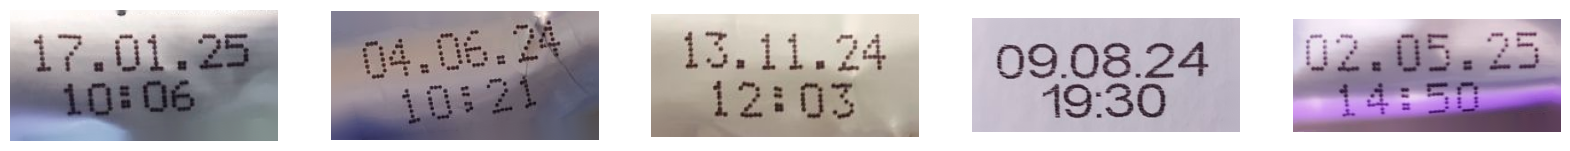

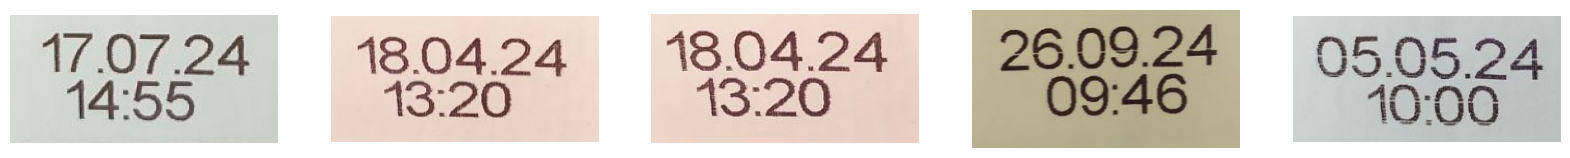

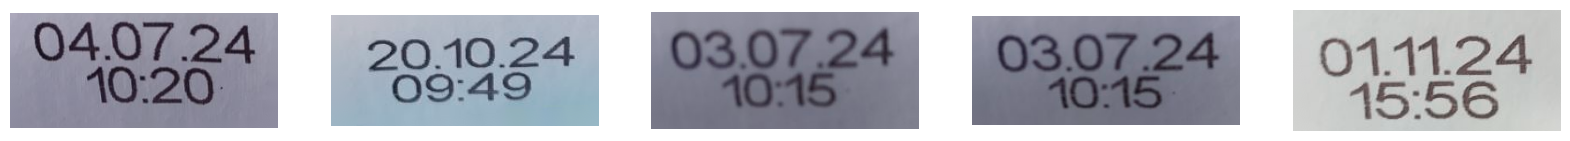

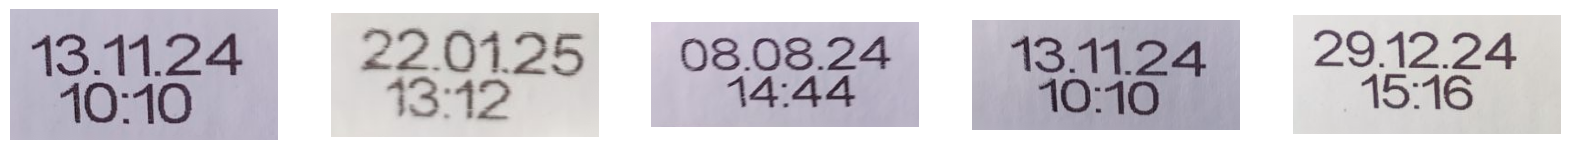

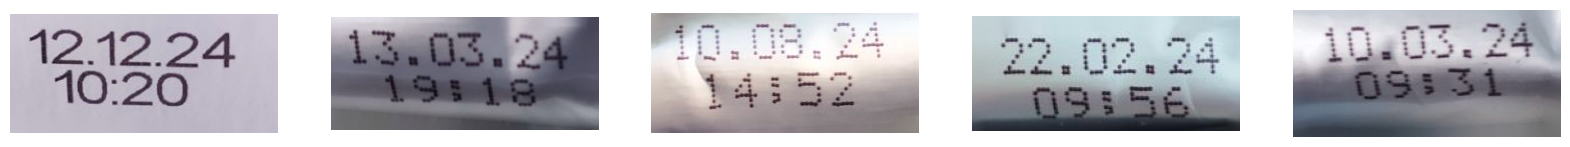

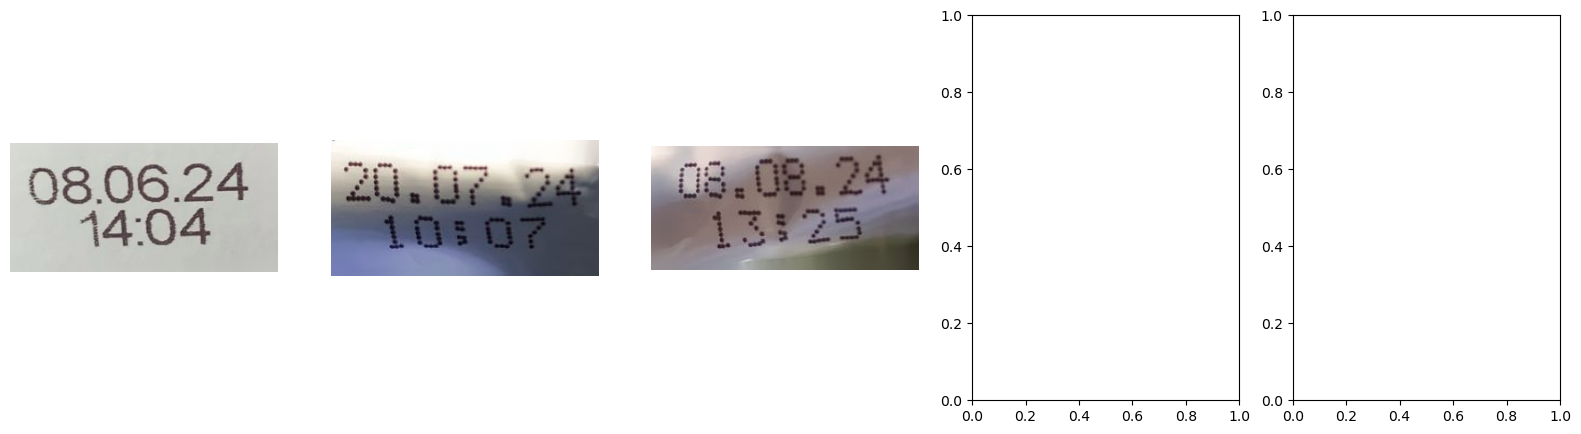

In [1]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

def fill_black_corners(image, threshold=5):
    # Create a mask where all channels are exactly zero
    mask = np.all(image <= threshold, axis=-1)
    
    # Use inpainting to fill in the black areas
    inpainted_image = cv2.inpaint(image, mask.astype(np.uint8), 3, cv2.INPAINT_TELEA)
    
    return inpainted_image

def enhance_text(image):
    # Convert image to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    kernel_size = 3
    max_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_size, kernel_size))

    alpha = .8   # Contrast control (1.0-3.0)
    beta = 0     # Brightness control (0-100)

    bilateral_filtered_image = cv2.bilateralFilter(gray_image, 5, 175, 175)
    more_denoised = cv2.fastNlMeansDenoising(bilateral_filtered_image, None, 13, 7, 21)

    contrast = cv2.convertScaleAbs(more_denoised, alpha=alpha, beta=beta)

    # Apply adaptive thresholding for better text visibility
    thresh = cv2.adaptiveThreshold(contrast, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                    cv2.THRESH_BINARY_INV, 11, 2)
    return thresh


def process_image(image_path):
    # Load the image
    image = cv2.imread(image_path)
    # Convert to RGB
    filled_image = fill_black_corners(image)

    # Enhance text for better extraction
    # text_image = enhance_text(filled_image)

    # Display the results
    return filled_image


# Path to the folder containing images
photos_path = "./data/soyjoy_cropped"

# List all files in the directory

# Process each photo if it ends with .png
count = 0
show_per_row = 5
photo_files = [f for f in os.listdir(photos_path) if os.path.isfile(os.path.join(photos_path, f))]
plastic_images = []
box_images = []
for photo_file in photo_files:
    if photo_file.endswith(".png"):
        photo_path = os.path.join(photos_path, photo_file)
        res = process_image(photo_path)
        if photo_file.split("_")[-2] == "2":
            box_images.append(res)
        else:
            plastic_images.append(res)
        if count % show_per_row == 0:
            fig, axs = plt.subplots(1, show_per_row, figsize=(20, 5))
        axs[count % show_per_row].imshow(res, cmap='gray')
        axs[count % show_per_row].axis('off')
        count += 1
        if count % show_per_row == 0:
            plt.show()

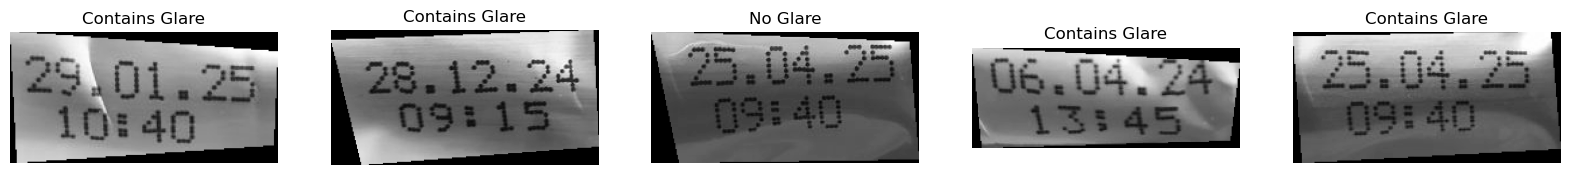

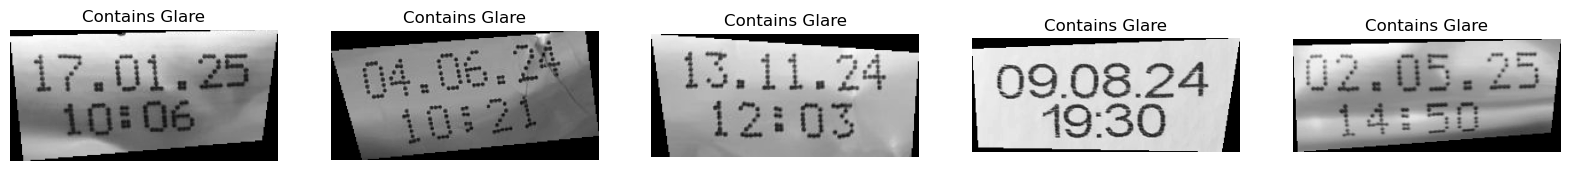

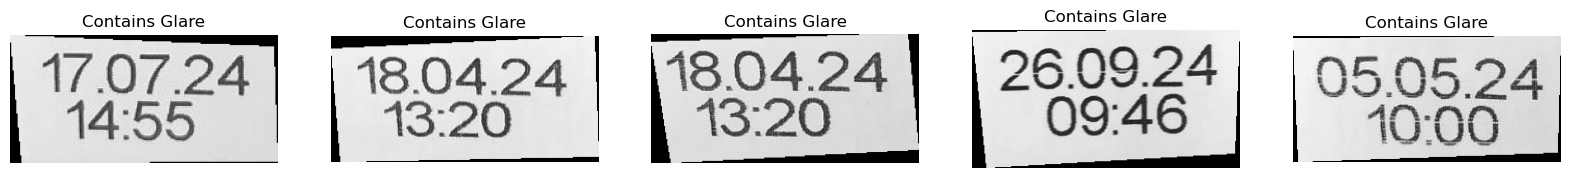

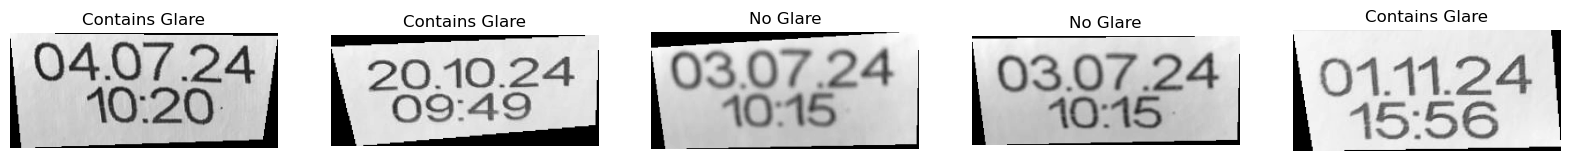

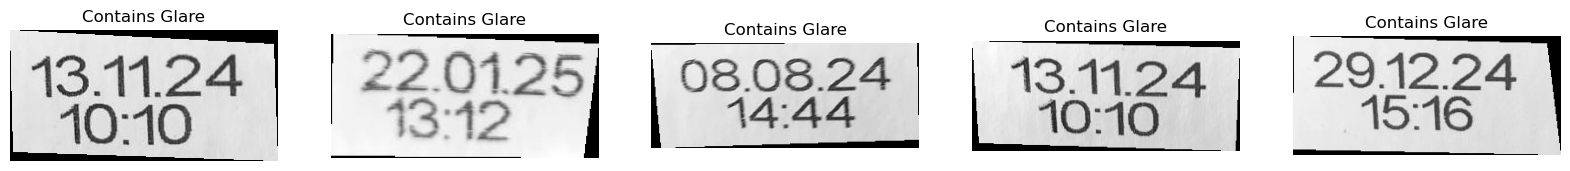

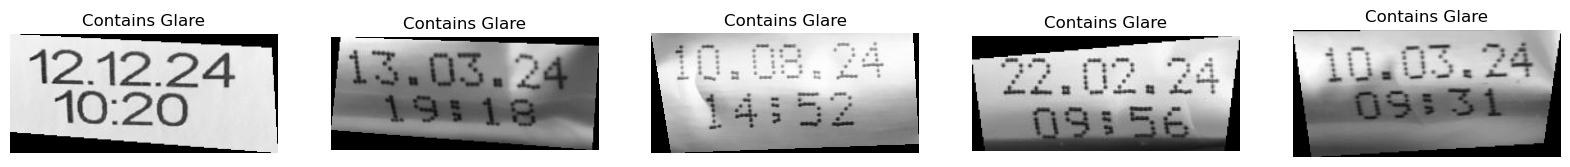

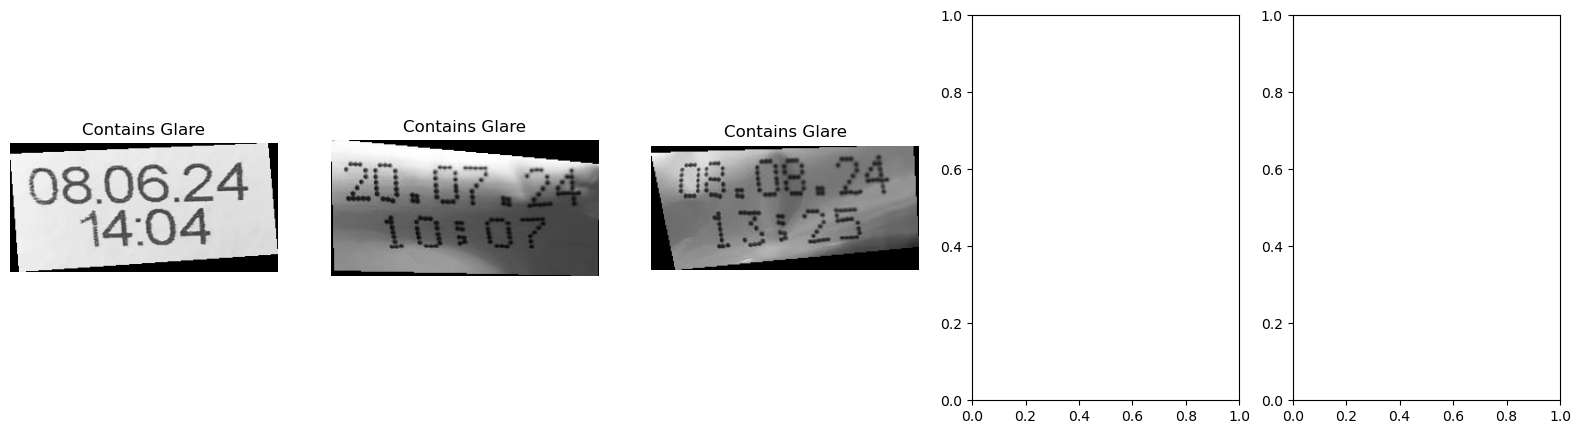

In [4]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

# Define glare detection function
def calculate_glare_metrics(image):
    # Calculate mean and variance of pixel intensities
    mean_intensity = np.mean(image)
    variance_intensity = np.var(image)
    
    # Calculate the percentage of bright pixels (indicative of glare)
    bright_pixel_count = np.sum(image > 200)  # Pixels with high intensity (greater than 200)
    bright_pixel_ratio = bright_pixel_count / (image.shape[0] * image.shape[1])
    
    return mean_intensity, variance_intensity, bright_pixel_ratio

def determine_glare(image):
    mean_intensity, variance_intensity, bright_pixel_ratio = calculate_glare_metrics(image)
    
    # Define thresholds to classify as glare or no glare
    mean_threshold = 180  # Example threshold for mean intensity
    variance_threshold = 2500  # Example threshold for intensity variance
    bright_pixel_ratio_threshold = 0.1  # Example threshold for bright pixel ratio (10%)
    
    # Determine if there is glare
    if mean_intensity > mean_threshold or variance_intensity > variance_threshold or bright_pixel_ratio > bright_pixel_ratio_threshold:
        return "Contains Glare"
    else:
        return "No Glare"

# Your previous code with glare detection added to the title of each photo
count = 0
show_per_row = 5
photos_path = "./data/soyjoy_cropped"  # Replace with your actual path
photo_files = [f for f in os.listdir(photos_path) if os.path.isfile(os.path.join(photos_path, f))]
plastic_images = []
box_images = []

for photo_file in photo_files:
    if photo_file.endswith(".png"):
        photo_path = os.path.join(photos_path, photo_file)
        
        # Load and process image
        image = cv2.imread(photo_path, cv2.IMREAD_GRAYSCALE)
        processed_image = image  # Assuming `process_image` is used here, modify as needed
        glare_label = determine_glare(processed_image)  # Determine if the image has glare

        # Append image based on label (for organization purposes)
        if photo_file.split("_")[-2] == "2":
            box_images.append(processed_image)
        else:
            plastic_images.append(processed_image)

        # Plot the image and set title based on glare detection
        if count % show_per_row == 0:
            fig, axs = plt.subplots(1, show_per_row, figsize=(20, 5))

        axs[count % show_per_row].imshow(processed_image, cmap='gray')
        axs[count % show_per_row].axis('off')
        axs[count % show_per_row].title.set_text(glare_label)  # Set the title as either "Contains Glare" or "No Glare"

        count += 1

        # Show the row of images after reaching the set limit
        if count % show_per_row == 0:
            plt.show()

# Show the remaining images if any
if count % show_per_row != 0:
    plt.show()


Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.
C:\Users\internship-ot2\AppData\Roaming\Python\Python312\site-packages\easyocr\detection.py:78: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an i

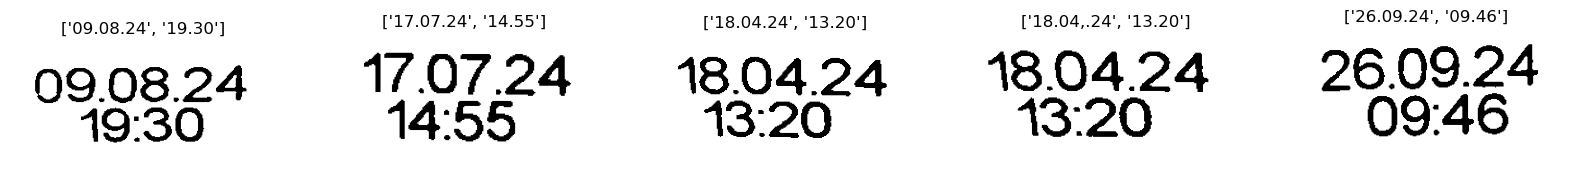

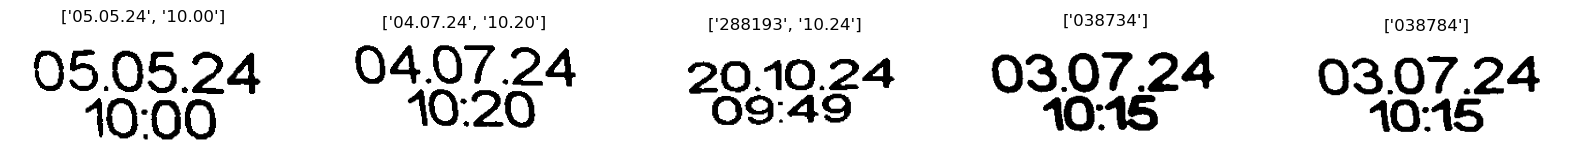

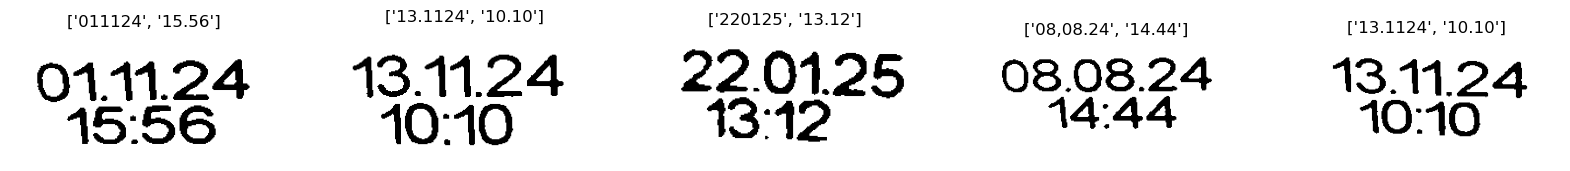

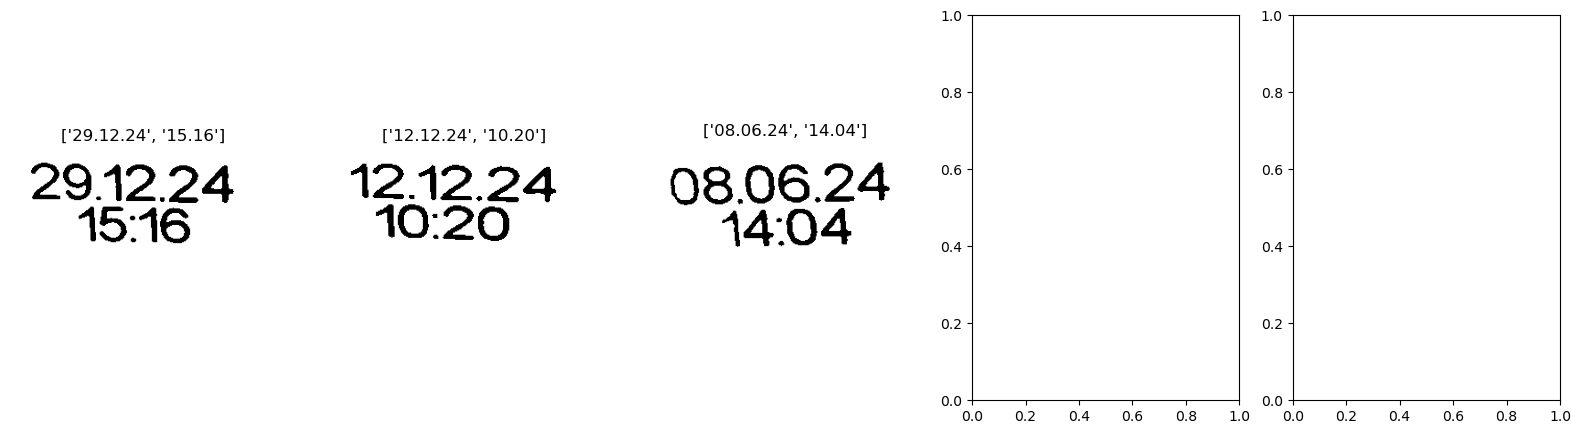

In [2]:
import easyocr
count = 0
show_per_row = 5
reader = easyocr.Reader(['en'])

def new_preproc(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
    return thresh
  
for image in box_images:
  res = new_preproc(image)
  text = reader.readtext(res,detail=0)
  if count % show_per_row == 0:
    fig, axs = plt.subplots(1, show_per_row, figsize=(20, 5))
  axs[count % show_per_row].title.set_text(text)
  axs[count % show_per_row].imshow(res, cmap='gray')
  axs[count % show_per_row].axis('off')
  count += 1
  if count % show_per_row == 0:
      plt.show()
    
    

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


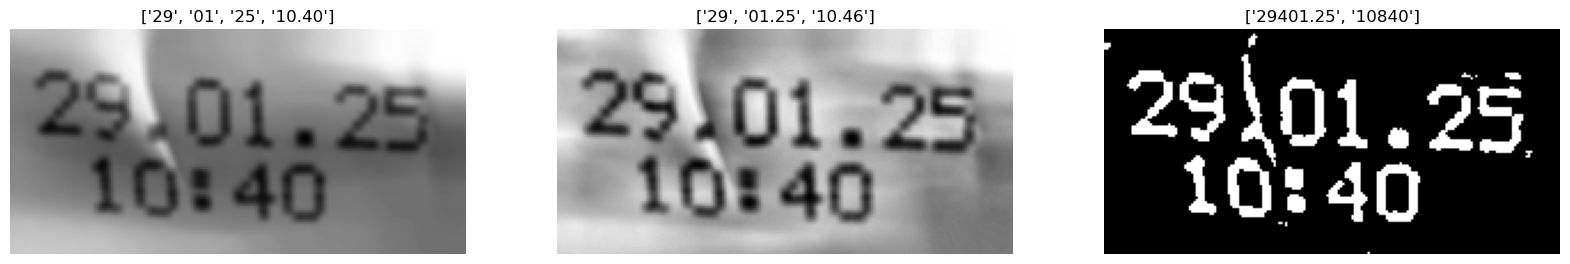

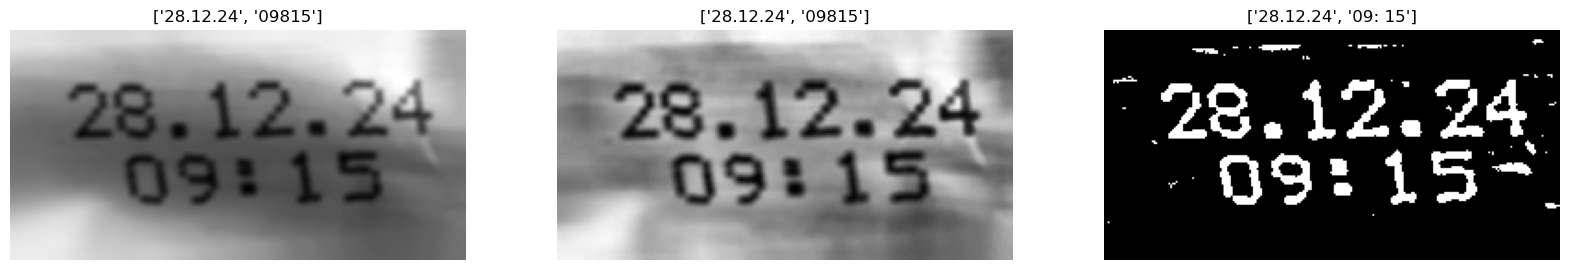

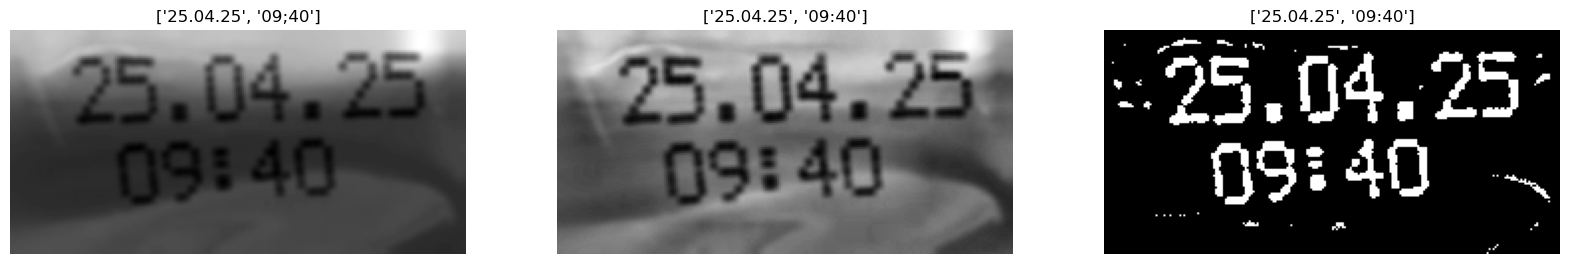

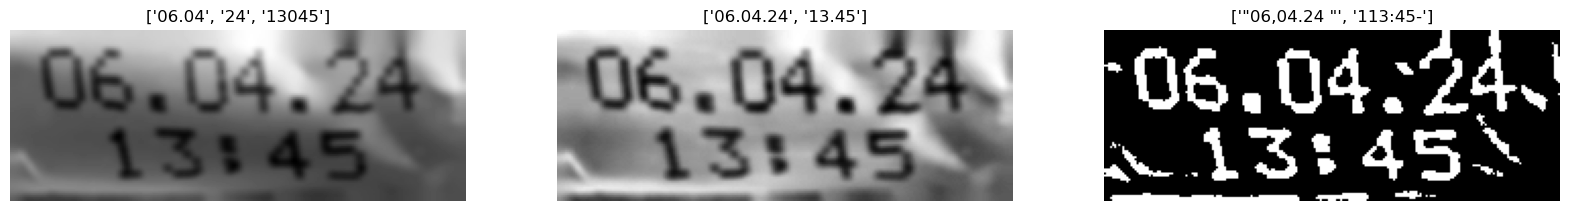

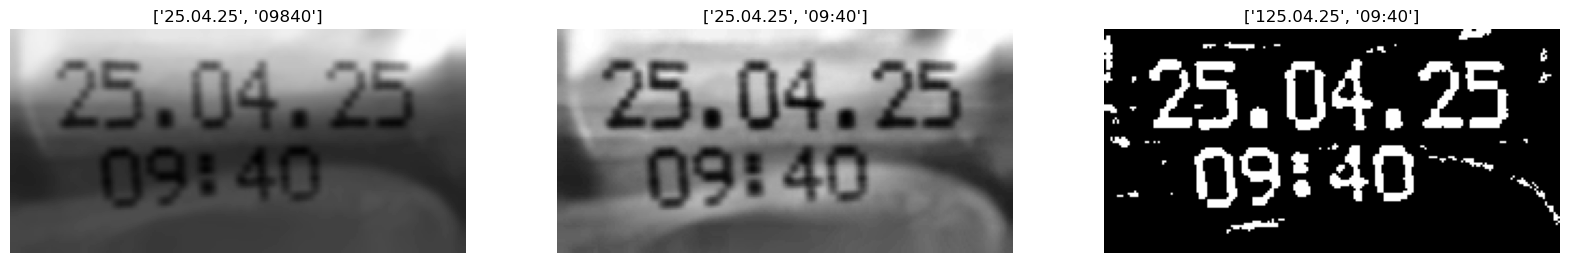

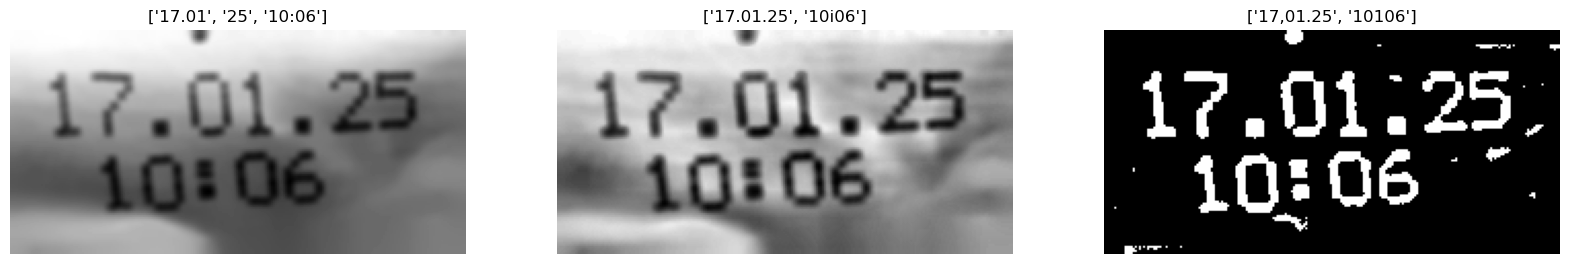

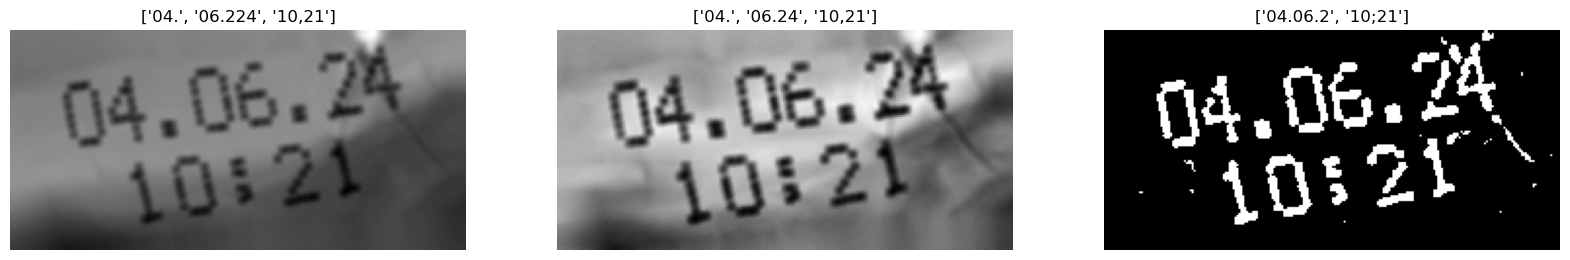

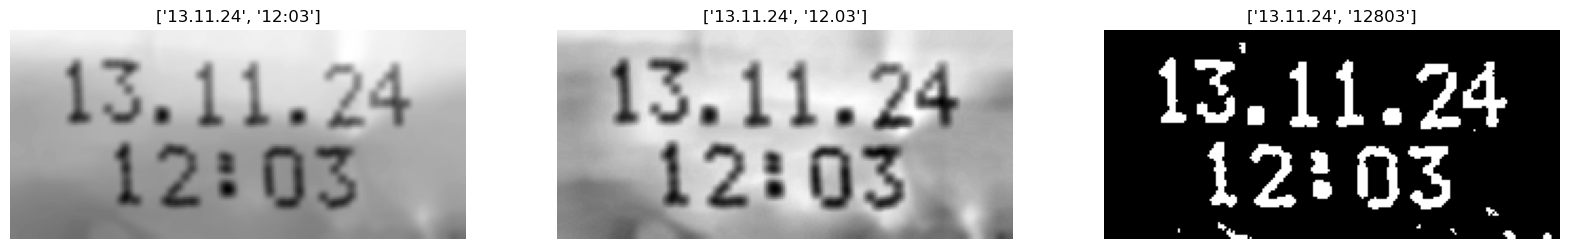

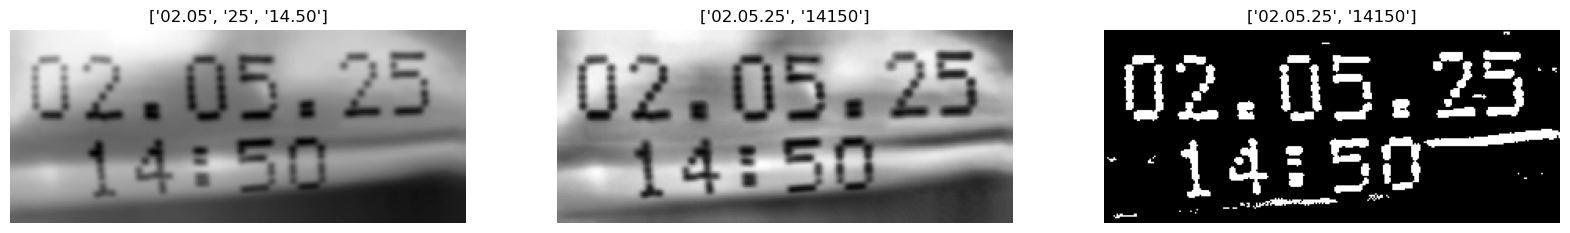

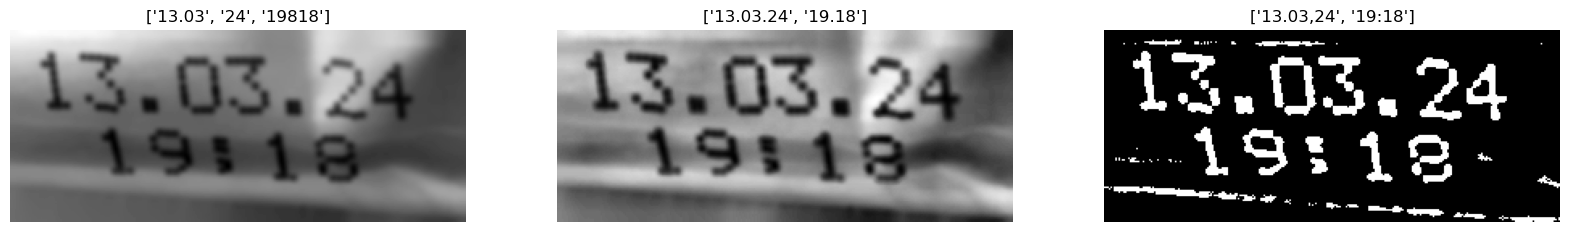

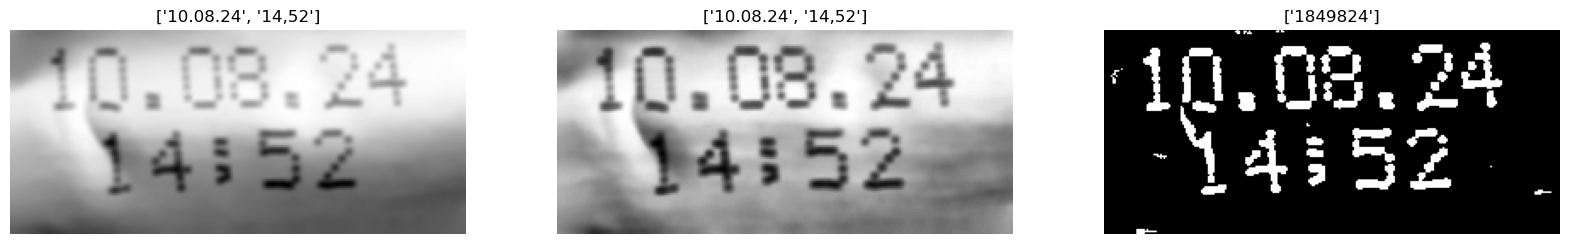

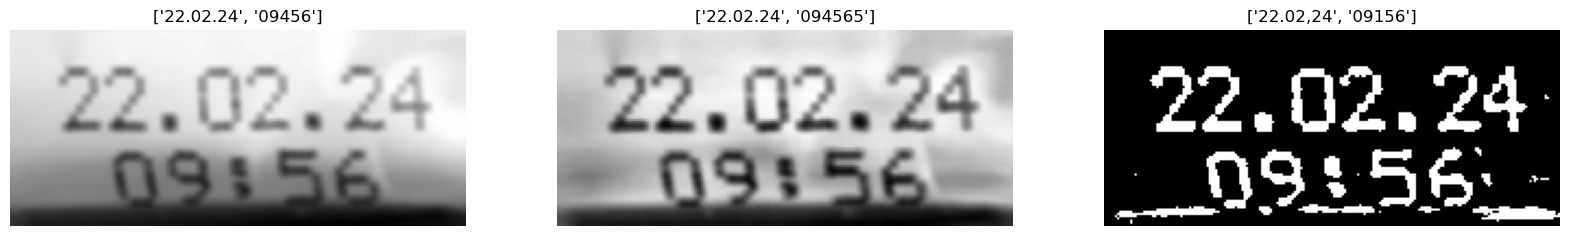

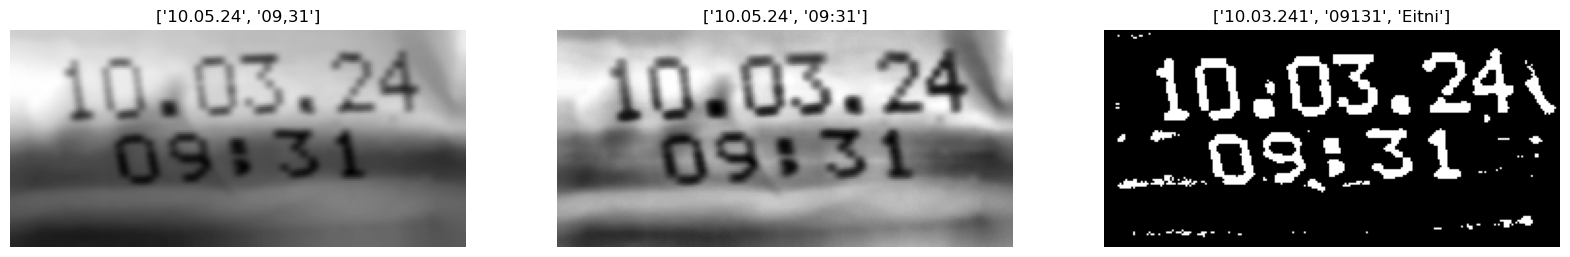

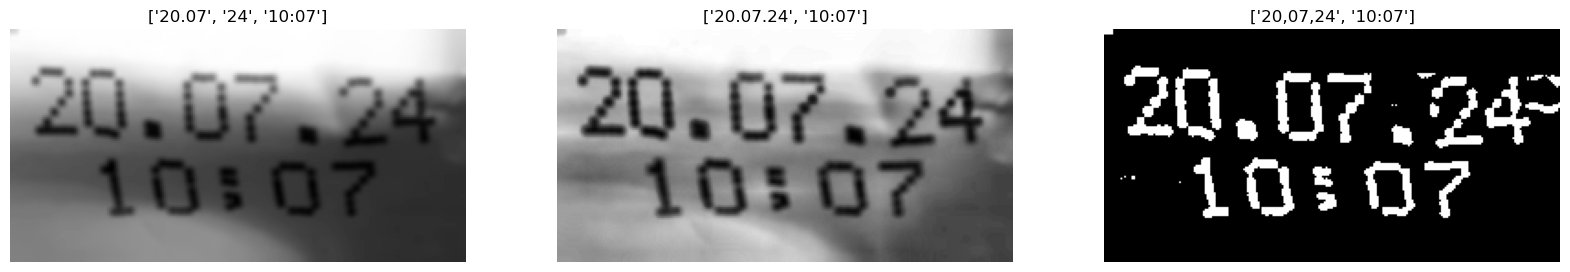

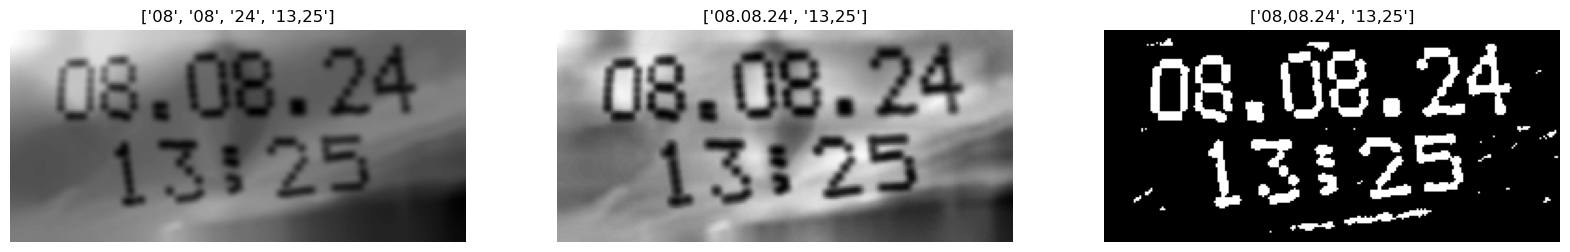

In [11]:
import easyocr

show_per_row = 3
reader = easyocr.Reader(['en'])
def new_preproc(image):
    stages = []
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 2)
    stages.append(gray)
    # remove glare using contrast limited adaptive histogram equalization
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    gray = clahe.apply(gray)
    stages.append(gray)
    
    # adaptive threshold
    thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 15, 9)
    stages.append(thresh)
    return stages    
    
for image in plastic_images:
  res = new_preproc(image)
  count = 0
  for stage in res:
      text = reader.readtext(stage,detail=0)
      if count % show_per_row == 0:
          fig, axs = plt.subplots(1, show_per_row, figsize=(20, 5))
      axs[count % show_per_row].title.set_text(text)
      axs[count % show_per_row].imshow(stage, cmap='gray')
      axs[count % show_per_row].axis('off')
      
      count += 1
      if count % show_per_row == 0:
          plt.show()
    

In [4]:
photo_files = [f for f in os.listdir(photos_path) if os.path.isfile(os.path.join(photos_path, f))]
for photo_file in photo_files:
    if photo_file.endswith(".png"):
      path = os.path.join(photos_path, photo_file)
      res = process_image(path)
      # save to ./data/more_cap_preprocessed
      cv2.imwrite(f"./data/more_cap_preprocessed/{photo_file}", res)
      print(f"Saved {photo_file}")
print("Done")

Saved 6267247567616197401_1_1.png
Saved 6267247567616197402_1_1.png
Saved 6267247567616197403_1_1.png
Saved 6267247567616197404_1_1.png
Saved 6267247567616197405_1_1.png
Saved 6267247567616197406_1_1.png
Saved 6267247567616197407_1_1.png
Saved 6267247567616197408_1_1.png
Saved 6267247567616197409_2_1.png
Saved 6267247567616197410_1_1.png
Saved 6267247567616197411_2_1.png
Saved 6267247567616197412_2_1.png
Saved 6267247567616197413_2_1.png
Saved 6267247567616197414_2_1.png
Saved 6267247567616197415_2_1.png
Saved 6267247567616197416_2_1.png
Saved 6267247567616197417_2_1.png
Saved 6267247567616197418_2_1.png
Saved 6267247567616197420_2_1.png
Saved 6267247567616197517_2_1.png
Saved 6267247567616197518_2_1.png
Saved 6267247567616197519_2_1.png
Saved 6267247567616197520_2_1.png
Saved 6267247567616197521_2_1.png
Saved 6267247567616197522_2_1.png
Saved 6267247567616197523_2_1.png
Saved 6267247567616197524_1_1.png
Saved 6267247567616197525_1_1.png
Saved 6267247567616197526_1_1.png
Saved 62672475